In [92]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy import integrate

In [2]:
mp_key = "zwe7ZzatCkKkvB6PUpwVmS0nGdBcJr1R"
mp_id = "mp-1569"

In [4]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Température de Debye

/tmp/ipykernel_1719034/2938911596.py:3: RuntimeWarning:

overflow encountered in scalar power

/tmp/ipykernel_1719034/2938911596.py:3: RuntimeWarning:

overflow encountered in exp

/tmp/ipykernel_1719034/2938911596.py:3: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_1719034/2938911596.py:3: RuntimeWarning:

overflow encountered in scalar multiply

/tmp/ipykernel_1719034/2938911596.py:12: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



Température suivant le modèle de Debye:  [1200.]


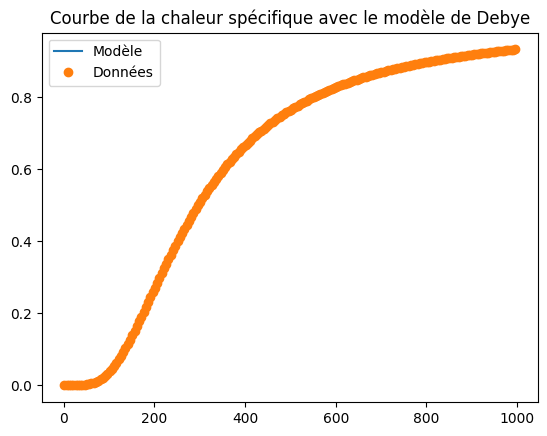

In [88]:
# Définition de la fonction utilisée dans l'intégrale
def f(x):
    return x**4 * np.exp(x) / (np.exp(x) - 1)**2

# Constantes
R = 8.314
nat = len(prim_struc)

# Définition de la fonction à fitter
def cvDebye(Tr):
    # Tr = température réduite = T/TD
    return 9. * nat * R * (Tr)**3 * np.array([integrate.quad(f, 0, 1./each_Tr)[0] for each_Tr in Tr])

# Définition de la fonction des résidus
def residuals(p, x, y):
    # Erreur entre y donné et y calculé
    return cvDebye(x / p[0]) - y

# Données expérimentales (T, Cv)
T = np.arange(1.,1000,5)
ph_cv = np.array([ph_dos.cv(T[i]) for i in range(len(T))])/(3*nat*R)

# Transformation en tableau numpy
liste = [[temp, chaleur] for temp, chaleur in zip(T, ph_cv)]
data = np.array(liste)

# Valeur initiale du paramètre recherché (TD)
p = [1200.]

# Fit par moindre carré
plsq = leastsq(residuals, p, args=(data[0], data[1]))

# Résultat
print("Température suivant le modèle de Debye: ", plsq[0])

# Graphe
x = np.arange(1.,1000,5)
plt.plot(x, cvDebye(x / plsq[0])/ (3. * nat * R), x, ph_cv, 'o')
plt.title("Courbe de la chaleur spécifique avec le modèle de Debye")
plt.legend(['Modèle', 'Données'])
plt.show()


# Température d'Einstein

/tmp/ipykernel_1719034/2289691356.py:4: RuntimeWarning:

overflow encountered in exp

/tmp/ipykernel_1719034/2289691356.py:4: RuntimeWarning:

invalid value encountered in divide



Température suivant le modèle d'Einstein:  [900.]


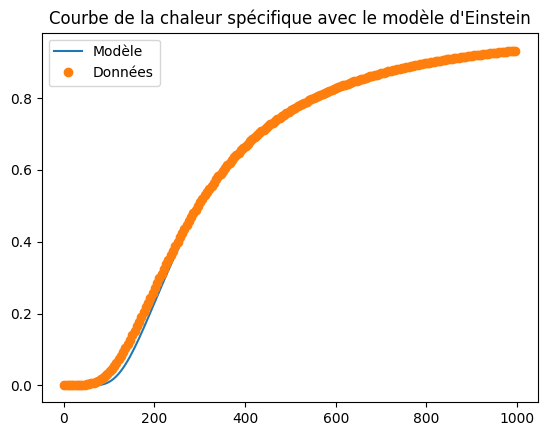

In [79]:
# Définition de la fonction à fitter
def cvEinstein(Tr):
    # Tr = température réduite = T/TE
    return 3. * nat * R * (1. / Tr) ** 2 * np.exp(1. / Tr) / (np.exp(1. / Tr) - 1) ** 2

# Définition de la fonction des résidus
def residuals(p, x, y):
    # Erreur entre y donné et y calculé
    return cvEinstein(x / p[0]) - y

# Constantes
R = 8.314
nat = len(prim_struc)

# Données expérimentales (T, Cv)
T = np.arange(1.,1000,5)
ph_cv = np.array([ph_dos.cv(T[i]) for i in range(len(T))])/(3*nat*R)

# Transformation en tableau numpy
liste = [[temp, chaleur] for temp, chaleur in zip(T, ph_cv)]
data = np.array(liste)

# Valeur initiale du paramètre recherché (TE)
p = [900.]

# Fit par moindre carré
plsq = leastsq(residuals, p, args=(data[0], data[1]))

# Résultat
print("Température suivant le modèle d'Einstein: ", plsq[0])

# Graphe
x = np.arange(1.,1000,5)
plt.plot(x, cvEinstein(x / plsq[0])/ (3. * nat * R), x, ph_cv, 'o')
plt.title("Courbe de la chaleur spécifique avec le modèle d'Einstein")
plt.legend(['Modèle', 'Données'])
plt.show()

# Chaleur spécifique

In [10]:
temperatures = np.arange(0,1000,5)
R = 8.314
nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R)

fig = go.Figure()
scatter = go.Scatter(x=temperatures, y=ph_cv)
fig.add_trace(scatter)
fig.add_hline(y=1, line_width=2, line_color="red")
fig.update_layout(
    xaxis =  {'mirror': True, 'showgrid': False, 'ticks': 'inside', 'ticklen':10},
    yaxis =  {'mirror': True, 'showgrid': False, 'ticks': 'inside', 'ticklen':10},
    xaxis_title = "Temperature",
    yaxis_title = "$C_{v} / (3N_{\mathrm{at}}R)$",
    title = "Courbe de la chaleur spécifique avec les données"
)
fig.show()

# Densités d'états de phonons

In [89]:
fig_ph_dos = get_plot_dos(ph_dos)
fig_ph_dos.show()

Pour le modèle de Debye : $k_B \Theta_D = \hbar \omega_D$.
Donc avec $\Theta_D = 1200 K$, on a $\omega_D = 1.5704 e14 s^{-1}$

$g_D(\omega) = 3N_{\text{at}} \delta(\omega - \omega_D)$

In [95]:
# Fréquence à laquelle la fonction delta est centrée
omega_D = 1.5704e14

# Constante
nat = len(prim_struc)

# Création de la fonction g_E(omega)
def g_D(omega):
    return 3 * nat * np.where(omega == omega_D, 1, 0)

# Calcul des valeurs de g_E pour chaque valeur de omega
frequences = get_dos_dict()
g_values = g_E(frequences)

# Tracé de la fonction
plt.plot(frequences, g_values)
plt.xlabel('Fréquence')
plt.ylabel('g_E')
plt.title("Densité d'état de phonons pour le modèle de Debye")
plt.show()

NameError: name 'get_dos_dict' is not defined

Pour le modèle d'Einstein : $k_B \Theta_E = \hbar \omega_E$.
Donc avec $\Theta_E = 900 K$, on a $\omega_E = 1.1778 e14 s^{-1}$